# Starting Multichannel Data

By Shooby on Sep 30th <br>
Last edited Oct 3rd

Idea is to use multi-channel data to do better deblending, know whether something is a different galaxy or just a blob within one. <br>
- Use a combination of HSC and Spitzer for detection and bring both to HST resolutions, so training from CANDELS
- USE CANDELS SEDs as possible options, fit for SED shapes from optical to spitzer

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image

def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im


def flux2mag(f):
    '''convert ujy flux to AB mag'''
    if f>0:
        m = np.log10(f)+23.9
    else:
        m = -99.0
    return m

In [8]:
gds = pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gds.fits')

In [340]:
def plot_sed(n):
    names=['ACS_F435W_FLUX','ACS_F606W_FLUX','ACS_F775W_FLUX','ACS_F850LP_FLUX','WFC3_F098M_FLUX','WFC3_F105W_FLUX','WFC3_F125W_FLUX','WFC3_F160W_FLUX','IRAC_CH1_FLUX','IRAC_CH2_FLUX','IRAC_CH3_FLUX','IRAC_CH4_FLUX']
    w = [435,606,775,850,980,1050,1250,1600,3600,4500,5700,7800]
    l,f = [],[]
    for boz in range(len(names)-2):
        if gds[names[boz]][n]>0:
            l.append(w[boz])
            #prin
            f.append(flux2mag(gds[names[boz]][n]))
    if len(f)>1:
        #f = f/max(f)
        plt.plot(l,f,c='r',alpha=1.0)
    return f

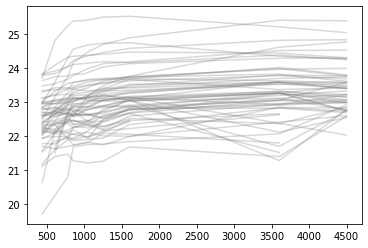

In [10]:
for i in range(60):
    n = np.random.randint(len(gds))
    plot_sed(n)

# Galaxy SED vs. galaxy pixels SEDs:

In [235]:
def distance_matrix(s):
    "outputs an sxs matrix with values being euclidean distance from the center"
    a = np.zeros((s,s))
    for i in range(0,s):
        for j in range(0,s):
            a[i,j] = (i-(s-1)/2)**2+(j-(s-1)/2)**2
    return a

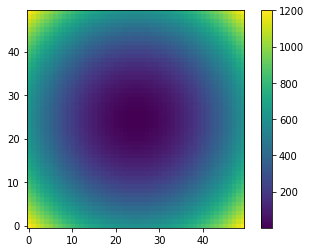

In [246]:
plt.imshow(distance_matrix(50),origin='lower')
plt.colorbar()

In [388]:

def segment(a1,above_mean=2,add_image_back=0.05,random_noise=0.1):
    '''Returns segmentation of an image by some filtering of lower level 
    noises, to restrict the fitting to the galaxy itself and mask the 
    surroundings'''
    im2=ndimage.gaussian_filter(a1, 2)
    mask = (im2 > above_mean*im2.mean()).astype(np.float)
    mask += add_image_back * im2
    img = mask + random_noise*np.random.randn(*mask.shape)
    hist, bin_edges = np.histogram(img, bins=60)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    binary_im = img > random_noise
    open_img = ndimage.binary_opening(binary_im)
    close_img = ndimage.binary_closing(open_img)
    return close_img

def pixels_sed(n):
    '''To plot SED of pixels within the galaxy on 
    top of the galaxy itself'''
    bband = cut(gds['RA_1'][n],gds['DEC_1'][n],15,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits')
    vband = cut(gds['RA_1'][n],gds['DEC_1'][n],15,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    iband = cut(gds['RA_1'][n],gds['DEC_1'][n],15,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
    zband = cut(gds['RA_1'][n],gds['DEC_1'][n],15,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')    
    y1band = cut(gds['RA_1'][n],gds['DEC_1'][n],15,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f098m_060mas_v1.0_drz.fits')
    yband = cut(gds['RA_1'][n],gds['DEC_1'][n],15,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f105w_060mas_v1.0_drz.fits')
    jband = cut(gds['RA_1'][n],gds['DEC_1'][n],15,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f125w_060mas_v1.0_drz.fits')
    hband = cut(gds['RA_1'][n],gds['DEC_1'][n],15,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
    
    
    
    seg = segment(zband)
    dist_m = distance_matrix(np.shape(bband)[0])
    
    injaha = (seg == True)
    
    b,v,i,z,y1,y,j,h = np.ndarray.flatten(bband[injaha]),np.ndarray.flatten(vband[injaha]),np.ndarray.flatten(iband[injaha]),np.ndarray.flatten(zband[injaha]),np.ndarray.flatten(y1band[injaha]),np.ndarray.flatten(yband[injaha]),np.ndarray.flatten(jband[injaha]),np.ndarray.flatten(hband[injaha])
    d = np.ndarray.flatten(dist_m[injaha])
    
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(iband*seg,origin='lower')
    plt.colorbar()
        
    lamb = [435,606,775,850,980,1050,1250,1600]

    plt.subplot(1,2,2)
    
    lower = d.min()
    upper = d.max()
    colors = plt.cm.viridis_r((d-lower)/(upper-lower))
    
    
    sum_f = np.zeros(len(lamb))
    for boz in range(len(b)):
        f=[b[boz],v[boz],i[boz],z[boz],y1[boz],y[boz],j[boz],h[boz]]
        l2,f2 = [],[]
        for l in range(len(lamb)):
            if f[l]>0:
                l2.append(lamb[l])
                f2.append(flux2mag(f[l]))
                sum_f[l]+=f[l]
        plt.plot(l2,f2,color=colors[boz],alpha=0.5)
    
    sum_mag = []
    for l in range(len(lamb)):
        sum_mag.append(flux2mag(sum_f[l]))
    
    plot_sed(n)
    plt.plot(lamb,sum_mag,'b.')
    plt.xlim([300,1700])
    plt.ylim([18,26])
    return iband

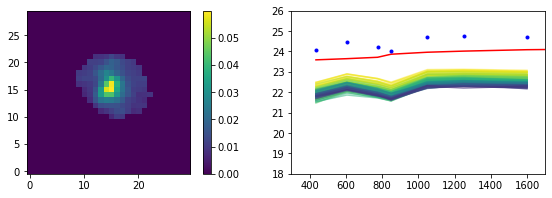

In [390]:
n = np.random.randint(len(gds))
ji = pixels_sed(n)